In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
raw_data = pd.read_csv('data/train.csv')
raw_test = pd.read_csv('data/test.csv')
raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


###  Column Definitions copied from Kaggle


| Variable | Definition | Key |
| :- | -: | :-: |
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex|  |	
|Age|Age in years	||
|sibsp|# of siblings / spouses aboard the Titanic	||
|parch|# of parents / children aboard the Titanic	||
|ticket|Ticket number	||
|fare|Passenger fare	||
|cabin|	Cabin number	||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

In [3]:
# Let's copy data into a new variable
# Remove Nominal features such as name, ticket id 

train_data = raw_data.copy()
train_data.set_index('PassengerId', inplace=True, drop=True)
print('Shape : ',train_data.shape)
print(train_data.info())

Shape :  (891, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


In [4]:
# Let's copy data into a new variable
# Remove Nominal features such as name, ticket id 

test_data = raw_test.copy()
test_data.set_index('PassengerId', inplace=True, drop=True)
print('Shape : ',test_data.shape)
print(test_data.info())

Shape :  (418, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB
None


- ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare'] => columns have data for all records
- Embarked has around 2 data missing
- We have only 25% data for Cabin. Cabin feature may correlate to survival, but here it's highly useless
- 20% data is missing in age -> We need to fill up this values


#### Age Adjustments 

reference : https://www.kaggle.com/allohvk/titanic-missing-age-imputation-tutorial-advanced

In [5]:
age_test_data = test_data.copy()
age_train_data = train_data.copy()

In [6]:
# we'll list out salutations out of  Names
def Create_salutation(df):
    Split_name1 = df['Name'].str.split(',', expand=True)
    Split_name2 = Split_name1[1].str.split('.', expand=True)
    Split_name2[0].unique()
    Split_name2[0]=Split_name2[0].str.replace(' ', '')
    df['salutation'] = Split_name2[0]
    
Create_salutation(age_test_data)
Create_salutation(age_train_data)

In [7]:
print('Train Data : ',age_train_data[age_train_data['Age'].isnull()]['salutation'].unique())
print('Data : ',age_test_data[age_test_data['Age'].isnull()]['salutation'].unique())

Train Data :  ['Mr' 'Mrs' 'Miss' 'Master' 'Dr']
Data :  ['Mr' 'Mrs' 'Miss' 'Ms' 'Master']


In [8]:
train_sample = age_train_data[age_train_data['salutation'].isin(['Mr', 'Mrs', 'Miss', 'Master', 'Dr'])]
train_age_summary = train_sample.groupby(['salutation', 'Pclass'])['Age'].agg(['mean', 'count'])
train_age_summary

mean  count
salutation Pclass                  
Dr         1       43.750000      4
           2       38.500000      2
Master     1        5.306667      3
           2        2.258889      9
           3        5.350833     24
Miss       1       30.000000     45
           2       22.390625     32
           3       16.123188     69
Mr         1       41.580460     87
           2       32.768293     82
           3       28.724891    229
Mrs        1       40.882353     34
           2       33.682927     41
           3       33.515152     33

In [9]:
list(train_age_summary['mean'])

[43.75,
 38.5,
 5.306666666666667,
 2.2588888888888885,
 5.350833333333333,
 30.0,
 22.390625,
 16.1231884057971,
 41.58045977011494,
 32.76829268292683,
 28.724890829694324,
 40.88235294117647,
 33.68292682926829,
 33.515151515151516]

In [10]:
age_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Name        891 non-null    object 
 3   Sex         891 non-null    object 
 4   Age         714 non-null    float64
 5   SibSp       891 non-null    int64  
 6   Parch       891 non-null    int64  
 7   Ticket      891 non-null    object 
 8   Fare        891 non-null    float64
 9   Cabin       204 non-null    object 
 10  Embarked    889 non-null    object 
 11  salutation  891 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 90.5+ KB


In [11]:
salutations = ['Dr','Master','Miss','Mr','Mrs']
pclasses = [1,2,3]
ages = [43.75,
 38.5,
 0,
 5.306666666666667,
 2.2588888888888885,
 5.350833333333333,
 30.0,
 22.390625,
 16.1231884057971,
 41.58045977011494,
 32.76829268292683,
 28.724890829694324,
 40.88235294117647,
 33.68292682926829,
 33.515151515151516]
for stn in range(len(salutations)):
    for pcl in range(len(pclasses)):
        age = (stn*3)+pcl
        age_train_data.loc[(age_train_data['Age'].isnull()) & (age_train_data['salutation']==salutations[stn]) & (age_train_data['Pclass'] == pclasses[pcl]),'Age'] = ages[age]        

In [12]:
age_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Name        891 non-null    object 
 3   Sex         891 non-null    object 
 4   Age         891 non-null    float64
 5   SibSp       891 non-null    int64  
 6   Parch       891 non-null    int64  
 7   Ticket      891 non-null    object 
 8   Fare        891 non-null    float64
 9   Cabin       204 non-null    object 
 10  Embarked    889 non-null    object 
 11  salutation  891 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 90.5+ KB


In [13]:
age_test_data[age_test_data['Age'].isnull()]['salutation'].unique()

array(['Mr', 'Mrs', 'Miss', 'Ms', 'Master'], dtype=object)

In [14]:
test_sample = age_test_data[age_test_data['salutation'].isin(['Mr', 'Mrs', 'Miss', 'Ms', 'Master'])]
test_age_summary = test_sample.groupby(['salutation', 'Pclass'])['Age'].agg(['mean', 'count'])
test_age_summary

mean  count
salutation Pclass                  
Master     1        9.500000      2
           2        5.000000      2
           3        7.454615     13
Miss       1       31.428571     14
           2       17.370000     16
           3       19.872647     34
Mr         1       41.200000     45
           2       31.718182     55
           3       27.198795     83
Mrs        1       45.606061     33
           2       33.000000     13
           3       29.875000     16
Ms         3             NaN      0

In [15]:
list(test_age_summary['mean'])

[9.5,
 5.0,
 7.454615384615384,
 31.428571428571427,
 17.37,
 19.872647058823528,
 41.2,
 31.71818181818182,
 27.198795180722893,
 45.60606060606061,
 33.0,
 29.875,
 nan]

In [16]:
ages_test = [9.5,
 5.0,
 7.454615384615384,
 31.428571428571427,
 17.37,
 19.872647058823528,
 41.2,
 31.71818181818182,
 27.198795180722893,
 45.60606060606061,
 33.0,
 29.875,
 29.875,
 29.875,
 29.875,]
salutations_test = ['Mr', 'Mrs', 'Miss', 'Ms', 'Master']
pclasses = [1,2,3]
for stn in range(len(salutations_test)):
    for pcl in range(len(pclasses)):
        age = (stn*3)+pcl
        age_test_data.loc[(age_test_data['Age'].isnull()) & (age_test_data['salutation']==salutations_test[stn]) & (age_test_data['Pclass'] == pclasses[pcl]),'Age'] = ages_test[age]        
        

In [17]:
age_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Name        418 non-null    object 
 2   Sex         418 non-null    object 
 3   Age         418 non-null    float64
 4   SibSp       418 non-null    int64  
 5   Parch       418 non-null    int64  
 6   Ticket      418 non-null    object 
 7   Fare        417 non-null    float64
 8   Cabin       91 non-null     object 
 9   Embarked    418 non-null    object 
 10  salutation  418 non-null    object 
dtypes: float64(2), int64(3), object(6)
memory usage: 39.2+ KB


### Check Point

In [32]:
pre_train_data = age_train_data
pre_test_data = age_test_data

#### Drop unnecessary columns

We can drop below columns which will not be much helpful

- Name 
- Ticket 
- Fare -> direct correlation with Pclass, ticket Fare may change but all will be treated as only 3 classes
- Cabin -> 75% data missing
- Embarked will not influence the survival
- salutation -> same as Name


In [33]:
pre_train_data.columns.values

array(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'salutation'], dtype=object)

In [34]:
drop_list = ['Name', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'salutation']
pre_train_data = pre_train_data.drop(drop_list, axis=1)
pre_test_data = pre_test_data.drop(drop_list,axis=1)

Transform Gender Male and female to 0 and 1

In [35]:
pre_train_data['Sex'] = pre_train_data['Sex'].map({'male':0, 'female':1})
pre_test_data['Sex'] = pre_test_data['Sex'].map({'male':0, 'female':1})

#### Explanatory Data Analysis 

In [39]:
pre_test_data

,Pclass,Sex,Age,SibSp,Parch
PassengerId,,,,,
892,3,0,34.500000,0,0
893,3,1,47.000000,1,0
894,2,0,62.000000,0,0
895,3,0,27.000000,0,0
896,3,1,22.000000,1,1
...,...,...,...,...,...
1305,3,0,7.454615,0,0
1306,1,1,39.000000,0,0
1307,3,0,38.500000,0,0


In [46]:
pre_train_data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.424948,0.523008,0.381594
std,0.486592,0.836071,0.477990,13.544457,1.102743,0.806057
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,28.724891,0.000000,0.000000
75%,1.000000,3.000000,1.000000,36.750000,1.000000,0.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000


We have 891 out of 2435 data points for training

- 38% people survived the event
- 35% of passengers were female
- youngest person aboard was 3 months old (0.42 yr), and oldest person was 80 years old

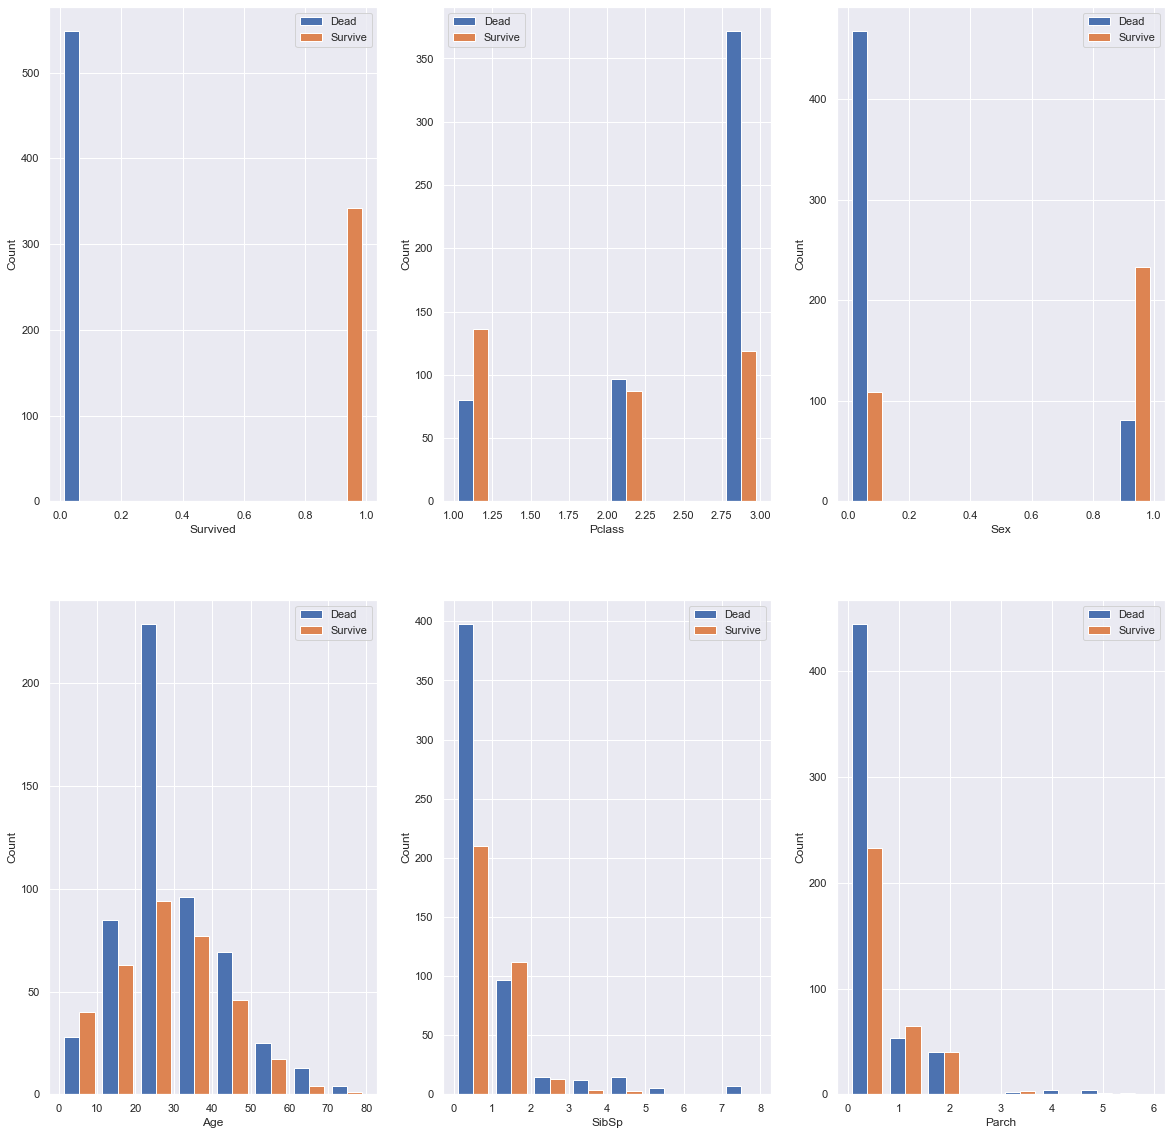

In [99]:
features = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
plt.figure(figsize=(20,20))

for ftr in range(len(features)):
    plt.subplot(2,3,ftr+1)
    plt.hist([pre_train_data[pre_train_data['Survived']==0][features[ftr]],pre_train_data[pre_train_data['Survived']==1][features[ftr]]],bins=8, label=["Dead", "Survive"])
    plt.legend()
    plt.xlabel(features[ftr])
    plt.ylabel('Count')



plt.show()

- in Pclass, Peaple in higher Class like 1 and 2 had more survival chance as compared to Class 3
- Majority of Male Died, but majoirity of Female survived. (In rescue boats, initially only Children and ladies were allowed, as a common practice)
- in Age group only Kids had more survival chance, same reason before
- Age group 20-30 had worst survival rate than all others
- in SibSp with 1 or 2 Siblings had better chance of surviving, If siblings aboard it's more likely these are kids than adult siblings traveling together
- Similar trend in Parch as well. If they had 1,2 or 3 parents or kids aboard, they have much higher chance of surviving

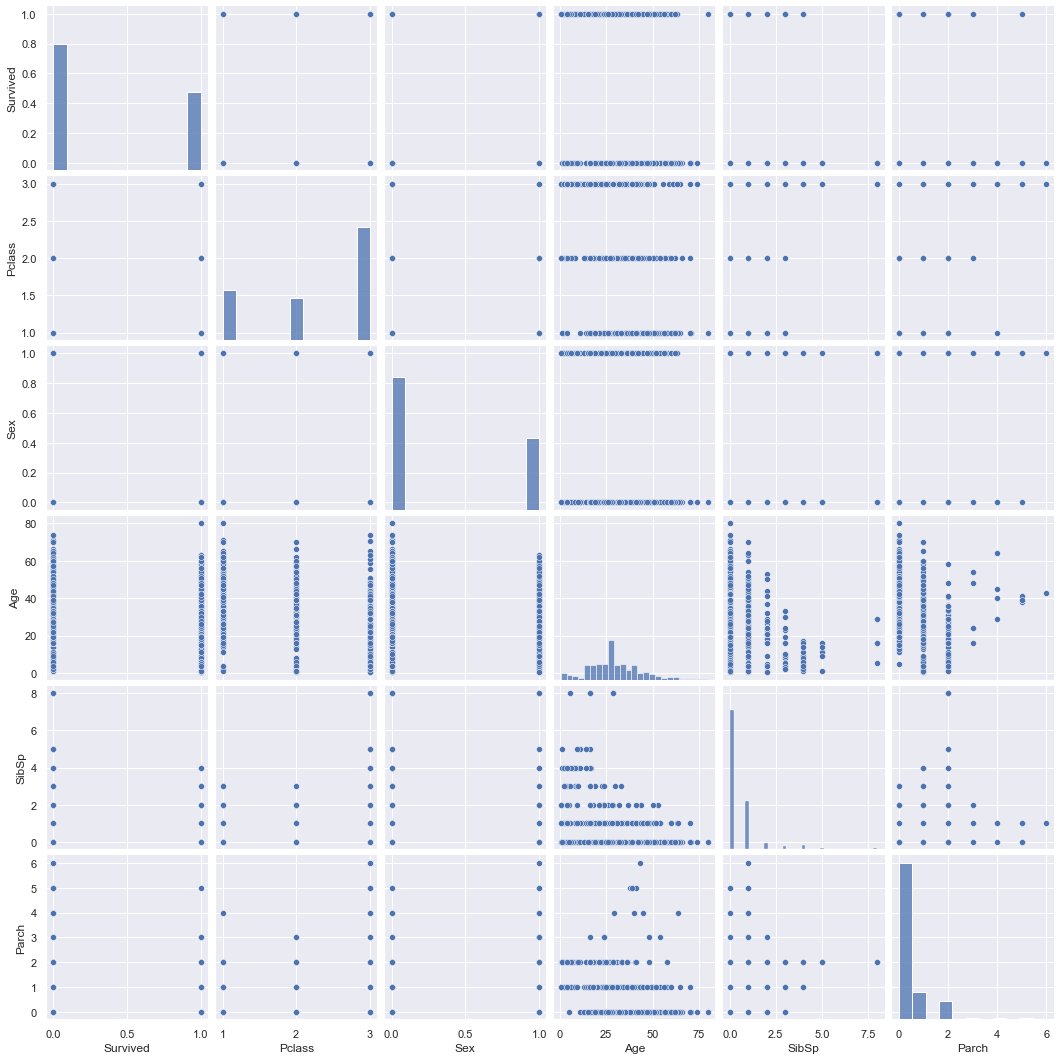

In [95]:
sns.pairplot(pre_train_data)

#### Scale and Transform data

In [116]:
X = pre_train_data.drop('Survived',axis=1)
Y = pre_train_data['Survived']

In [128]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2, random_state = 42 )
x_train, x_test = X_train, X_test

In [129]:
scaler = StandardScaler()
scaler.fit(X)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### Logistic Regression Model 

In [133]:
from sklearn.linear_model import LogisticRegression
logisticRegressionModel = LogisticRegression()

In [147]:
logisticRegressionModel.fit(x_train, y_train)
round(logisticRegressionModel.score(x_train,y_train),2)

0.8

In [162]:
y_pred_logReg = logisticRegressionModel.predict(x_test)
round(accuracy_score(y_test, y_pred_logReg),2)

0.83

### Supporting Vector Classifiers

In [169]:
from sklearn.svm import SVC, LinearSVC
svc = SVC()
svc.fit(x_train, y_train)
round(svc.score(x_train, y_train),2)

0.84

In [166]:
y_pred_svc = svc.predict(x_test)
round(accuracy_score(y_test, y_pred),2)

0.79

### Linear Supporting Vector Classifiers

In [193]:
linear_svc = LinearSVC()
linear_svc.fit(x_train,y_train)
round(linear_svc.score(x_train,y_train),2)

0.8

In [170]:
y_pred_linear_svc = linear_svc.predict(x_test)
round(accuracy_score(y_test, y_pred_linear_svc),2)

0.79

###  Random Forest Classifier

In [171]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
round(rfc.score(x_train, y_train),2)

0.92

In [172]:
y_pred_rfc = rfc.predict(x_test)
round(accuracy_score(y_test, y_pred_rfc),2)

0.82

###  KNN Classifier

In [175]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()
KNN.fit(x_train, y_train)
round(KNN.score(x_train, y_train),2)

0.85

In [177]:
y_pred_knn = KNN.predict(x_test)
round(accuracy_score(y_test, y_pred_knn),2)

0.8

###  Gaussian Naive Bayes

In [178]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
GNB.fit(x_train, y_train)
round(GNB.score(x_train, y_train),2)

0.78

In [179]:
y_pred_gnb = GNB.predict(x_test)
round(accuracy_score(y_test, y_pred_gnb),2)

0.75

###  Perceptron

In [180]:
from sklearn.linear_model import Perceptron

perc = Perceptron()
perc.fit(x_train, y_train)
round(perc.score(x_train, y_train),2)

0.64

In [181]:
y_pred_perc = perc.predict(x_test)
round(accuracy_score(y_test, y_pred_perc),2)

0.65

### Stochastic Gradient Descent Classifier

In [183]:
from sklearn.linear_model import SGDClassifier

SGD = SGDClassifier()
SGD.fit(x_train, y_train)
round(SGD.score(x_train, y_train),2)

0.78

In [184]:
y_pred_sgd = SGD.predict(x_test)
round(accuracy_score(y_test, y_pred_sgd),2)

0.83

### Decision Tree Classifier

In [185]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()
DTC.fit(x_train, y_train)
round(DTC.score(x_train, y_train),2)

0.92

In [188]:
y_pred_dtc = DTC.predict(x_test)
round(accuracy_score(y_test, y_pred_dtc),2)

0.78

### Saving Submissions

In [216]:
submissionDF = pre_test_data.copy()
submissionDF = submissionDF.drop(['Pclass','Sex','Age','SibSp','Parch'],axis=1)
testData = scaler.transform(pre_test_data)

In [226]:
# Random Forest 71%
RFC_df = submissionDF
y_pred_rfc = rfc.predict(testData)

RFC_df['Survived'] = y_pred_rfc
RFC_df = RFC_df.sort_index()
RFC_df.to_csv('data/rfc.csv')

In [227]:
#SVC = 78 %
SVC_df = submissionDF
y_pred_svc = svc.predict(testData)
SVC_df['Survived'] = y_pred_svc
SVC_df.to_csv('data/svc.csv')

In [228]:
# Linear SVC = 76.6 %
LSVC_df = submissionDF
y_pred_lsvc = linear_svc.predict(testData)
LSVC_df['Survived'] = y_pred_lsvc
LSVC_df.to_csv('data/lsvc.csv')

In [229]:
# Logistic Regression = 75.36 %
LR_df = submissionDF
y_pred_lr = logisticRegressionModel.predict(testData)
LR_df['Survived'] = y_pred_lr
LR_df.to_csv('data/logisticRegression.csv')


In [230]:
# KNN = 74.64 %
KNN_df = submissionDF
y_pred_KNN = KNN.predict(testData)
KNN_df['Survived'] = y_pred_KNN
KNN_df.to_csv('data/KNN.csv')

In [231]:
# GNB = 74.16 %
GNB_df = submissionDF
y_pred_GNB = GNB.predict(testData)
GNB_df['Survived'] = y_pred_GNB
GNB_df.to_csv('data/GNB.csv')

In [232]:
# perc = 61.244 %
perc_df = submissionDF
y_pred_perc = perc.predict(testData)
perc_df['Survived'] = y_pred_perc
perc_df.to_csv('data/perc.csv')

In [233]:
# SGD = 73.44 %
SGD_df = submissionDF
y_pred_SGD = SGD.predict(testData)
SGD_df['Survived'] = y_pred_SGD
SGD_df.to_csv('data/SGD.csv')

In [234]:
# DTC = 63.88 %
DTC_df = submissionDF
y_pred_DTC = DTC.predict(testData)
DTC_df['Survived'] = y_pred_DTC
DTC_df.to_csv('data/DTC.csv')